In [1]:
# Improved and updated DEG_analysis_062020.ipynb
##Ver.031721
import pandas as pd
import rpy2
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, Formula
pandas2ri.activate()
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
'''
Adopted from:  https://stackoverflow.com/questions/41821100/running-deseq2-through-rpy2
and also from: https://gist.github.com/wckdouglas/3f8fb27a3d7a1eb24c598aa04f70fb25
Using DESeq2 in python
'''

import os, sys, time,re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.lines as mlines
from matplotlib.gridspec import  GridSpec
import seaborn as sns

from scipy import stats
from scipy.cluster import hierarchy
from statsmodels.stats.multitest import multipletests
from collections import defaultdict
import pysam
from collections import defaultdict
import statsmodels.api as sm
from class_gene import *

REFFLAT_hg38      = '/extdata1/baeklab/Doyeon/SARSCOV2/ref/hg38/annotations/r171015.txt'
REFFLAT_chlSab2   = '/extdata1/baeklab/Doyeon/SARSCOV2/ref/chlSab2.genes.refFlat.rearranged.txt' #green monkey Vero cell
REFFLAT_SARSCOV2      = '/extdata1/baeklab/Doyeon/SARSCOV2/ref/SARSCOV2_annotation_021921.txt' ##updated: correct end position for ORF1a

BAMDIR_hostmapped = '/extdata1/baeklab/Doyeon/SARSCOV2/data/%s_hostalign_021721/%s.bam' #e.g. %('mRNASeq','mRNA_2h_rep1') %('RPFSeq','QTI_0h_rep2')
BAMDIR_cov2mapped = '/extdata1/baeklab/Doyeon/SARSCOV2/data/%s_SARSCOV2align_021721/%s.bam' 
RPKMDIR           = '/extdata1/baeklab/Doyeon/SARSCOV2/data/rpkm_021721/%s.txt' #%('mRNA_2h_rep1')

GENELISTDIR  = '/extdata1/baeklab/Doyeon/SARSCOV2/ref/%s.txt'

RESULTDIR    = '/extdata1/baeklab/Doyeon/SARSCOV2/result/%s' #e.g. %('timecourse_SARSCOV2exp/021721_mRNA_quantification.tsv')
FIGDIR       = '/extdata1/baeklab/Doyeon/SARSCOV2/fig/%s' #e.g. %('revision_QC/021721_QTISeq_12h.pdf')
fontfiles    = fm.findSystemFonts(fontpaths='/extdata1/baeklab/Doyeon/fonts', fontext='ttf')
fontlist     = fm.createFontList(fontfiles)
fm.fontManager.ttflist.extend(fontlist)
plt.style.use('file:///home/sonic/.config/matplotlib/Doyeon.mplstyle')

%matplotlib inline


## DESeq R package

In [2]:
'''
For install DESeq2 packages:
open R: ~/baeklab/Hyeonseong/anaconda3/envs/Doyeon-tf2/bin/R
> install.packages("BiocManager")
> BiocManager::install("DESeq2")
loooooooong time required for installing dependent packages
'''

deseq2 = importr('DESeq2')
to_dataframe = ro.r('function(x) data.frame(x)')
deseq1 = importr('DESeq')
BiocGenerics = importr('BiocGenerics')
#print(sorted(list(dir(deseq1))))
#sorted(list(dir(BiocGenerics)))

In [3]:
class py_DESeq1:
    '''
    DESeq (version 1) object through rpy2
    input:
    count_matrix: should be a pandas dataframe with each column as count, and a id column for gene id
        example:
        id    sampleA    sampleB
        geneA    5    1
        geneB    4    5
        geneC    1    2
    design_matrix: an design matrix in the form of pandas dataframe, see DESeq1 manual, samplenames as rownames
                treatment
    sampleA1        A
    sampleA2        A
    sampleB1        B
    sampleB2        B
    design_formula: see DESeq1 manual, example: "~ treatment""
    gene_column: column name of gene id columns, example "id"
    '''
    def __init__(self, count_matrix, design_matrix, design_formula, gene_column='id'):
        try:
            assert gene_column in count_matrix.columns, 'Wrong gene id column name'
            gene_id = count_matrix[gene_column]
        except AttributeError:
            sys.exit('Wrong Pandas dataframe?')

        self.cds = None
        self.deseq_result = None
        self.deseq_result_Robj = None
        self.resLFC = None
        
        self.normalized_count_matrix = None
        self.gene_column = gene_column
        self.gene_id = count_matrix[self.gene_column]
        #renamed_matrix = count_matrix.rename(columns={index: row['treatment']for index,row in design_matrix.iterrows()})
        #display(renamed_matrix.drop(gene_column,axis=1).head())
        #display(count_matrix.drop(gene_column,axis=1).head())
        #display(design_matrix)
        with localconverter(ro.default_converter + pandas2ri.converter):
            self.count_matrix = ro.conversion.py2rpy(count_matrix.drop(gene_column,axis=1))
            self.design_matrix = ro.conversion.py2rpy(design_matrix['treatment'])
        self.design_formula = Formula(design_formula)


    def run_deseq(self, **kwargs):
        
        self.cds = deseq1.newCountDataSet(self.count_matrix,self.design_matrix)
        self.cds = BiocGenerics.estimateSizeFactors(self.cds)
        self.cds = BiocGenerics.estimateDispersions(self.cds,modelFrame=self.design_matrix)
        #print(self.cds)
        #print(BiocGenerics.counts(self.cds))
        #print(BiocGenerics.conditions(self.cds))
        self.deseq_result_Robj = deseq1.nbinomTest( self.cds, "A", "B" )

        
    def get_deseq_result(self,lfc_shrink=True, **kwargs):
        ##For DESeq1, lfc shrink is not available
        self.deseq_result = to_dataframe(self.deseq_result_Robj)
        #print(type(self.deseq_result))
        with localconverter(ro.default_converter + pandas2ri.converter):
            self.deseq_result = ro.conversion.rpy2py(self.deseq_result) ## back to pandas dataframe
        
        self.deseq_result[self.gene_column] = self.gene_id.values
        
    

In [4]:
class py_DESeq2:
    '''
    DESeq2 object through rpy2
    input:
    count_matrix: should be a pandas dataframe with each column as count, and a id column for gene id
        example:
        id    sampleA    sampleB
        geneA    5    1
        geneB    4    5
        geneC    1    2
    design_matrix: an design matrix in the form of pandas dataframe, see DESeq2 manual, samplenames as rownames
                treatment
    sampleA1        A
    sampleA2        A
    sampleB1        B
    sampleB2        B
    design_formula: see DESeq2 manual, example: "~ treatment""
    gene_column: column name of gene id columns, exmplae "id"
    '''
    def __init__(self, count_matrix, design_matrix, design_formula, gene_column='id'):
        try:
            assert gene_column in count_matrix.columns, 'Wrong gene id column name'
            gene_id = count_matrix[gene_column]
        except AttributeError:
            sys.exit('Wrong Pandas dataframe?')

        self.dds = None
        self.deseq_result = None
        self.deseq_result_Robj = None
        self.resLFC = None
        self.comparison = None
        self.normalized_count_matrix = None
        self.gene_column = gene_column
        self.gene_id = count_matrix[self.gene_column]
        with localconverter(ro.default_converter + pandas2ri.converter):
            self.count_matrix = ro.conversion.py2rpy(count_matrix.drop(gene_column,axis=1))
            self.design_matrix = ro.conversion.py2rpy(design_matrix)
        self.design_formula = Formula(design_formula)


    def run_deseq(self, **kwargs):
        self.dds = deseq2.DESeqDataSetFromMatrix(countData=self.count_matrix, 
                                        colData=self.design_matrix,
                                        design=self.design_formula)
        
        
        self.dds = deseq2.DESeq(self.dds, **kwargs)
        
        
        

    def get_deseq_result(self,lfcshrink=True, **kwargs):

        self.comparison = deseq2.resultsNames(self.dds)
        if lfcshrink:
            self.deseq_result_Robj = deseq2.lfcShrink(self.dds,coef='treatment_B_vs_A',type='apeglm',**kwargs)
        else:
            self.deseq_result_Robj = deseq2.results(self.dds, **kwargs)
        self.deseq_result = to_dataframe(self.deseq_result_Robj)
        #print(type(self.deseq_result))
        with localconverter(ro.default_converter + pandas2ri.converter):
            self.deseq_result = ro.conversion.rpy2py(self.deseq_result) ## back to pandas dataframe
        
        self.deseq_result[self.gene_column] = self.gene_id.values
        
#@ri2py.register(DataFrame)
#def ri2py_dataframe(obj):
#    # items = tuple((k, ri2py(v)) for k, v in obj.items())
#    # res = PandasDataFrame.from_items(items)
#    items = OrderedDict((k, ri2py(v)) for k, v in obj.items())
#    res = PandasDataFrame.from_dict(items)
#    return res    

## Basic functions

In [5]:
def load_RPKM(samplename):
    '''
    id	symbol	ef_length	nsegments1	nsegments2	nsegments3	readcount	readcount_uniq	exlev	exrnk	expct
    NM_006004	UQCRH	276	18702	18702	18494	9250.416666666679	32	27048.868164275482	1.0	0.005263989050902774
    '''
    df = pd.read_csv(RPKMDIR %samplename,sep='\t')
    df = df.rename(columns={'id':'NMID','symbol':'gsym',
                            'readcount':'nreads','exlev':'RPKM'})
    
    df['gsym'] = df['gsym'].str.upper()
    
    df['nreads'] = df['nreads'].round(0)
    df = df[['NMID','gsym','nreads','RPKM','exrnk','expct']]
    df = df.set_index('NMID')
    return df

## Fig. 5a (Functions for DEG identification and plotting)

### DEG identification

In [6]:
## previously identify_DEG_v2 in DEG_analysis_062020.ipynb
def identify_DEG(infected=[],uninfected=[], DEG_method=py_DESeq2, verbose=False,
                 OutF = ''): #default: DESeq2.
    ## infected samples
    nread_df      = load_RPKM(infected[0])
    infected_nreads_df         = nread_df[['gsym','nreads']]
    infected_nreads_df.columns = ['gsym',infected[0]]
    infected_expct_df          = nread_df[['gsym','expct']]
    infected_expct_df.columns  = ['gsym',infected[0]+'_expct']
    for samplename in infected[1:]:
        nread_df = load_RPKM(samplename)
        infected_nreads_df[samplename]         = nread_df['nreads']
        infected_expct_df[samplename+'_expct'] = nread_df['expct']
    infected_expct_df = infected_expct_df.set_index(['gsym']).mean(axis=1) #average expct
    ##
    ## uninfected samples
    nread_df      = load_RPKM(uninfected[0])
    uninfected_nreads_df         = nread_df[['gsym','nreads']]
    uninfected_nreads_df.columns = ['gsym',uninfected[0]]
    uninfected_expct_df          = nread_df[['gsym','expct']]
    uninfected_expct_df.columns  = ['gsym',uninfected[0]+'_expct']
    for samplename in uninfected[1:]:
        nread_df = load_RPKM(samplename)
        uninfected_nreads_df[samplename]         = nread_df['nreads']
        uninfected_expct_df[samplename+'_expct'] = nread_df['expct']
    uninfected_expct_df = uninfected_expct_df.set_index(['gsym']).mean(axis=1) #average expct
    ##
    
    #for convenience, replace gsym to index and drop nmid
    infected_nreads_df   = infected_nreads_df.reset_index(drop=True)
    infected_nreads_df   = infected_nreads_df.set_index(['gsym'])
    uninfected_nreads_df = uninfected_nreads_df.reset_index(drop=True)
    uninfected_nreads_df = uninfected_nreads_df.set_index(['gsym'])
    
    count_mat = pd.concat([infected_nreads_df,uninfected_nreads_df],axis=1)
    count_mat = count_mat.reset_index()
    count_mat = count_mat.rename(columns={'index':'id'})
    #display(count_mat.head())
    design_mat= pd.DataFrame(['B' for i in range(len(infected))]+['A' for i in range(len(uninfected))],
                          index=infected+uninfected)
    design_mat.columns = ['treatment']
    #display(design_mat)
    
    DESeq = DEG_method(count_mat,design_mat,design_formula='~ treatment',gene_column='id')
    DESeq.run_deseq()
    DESeq.get_deseq_result(lfcshrink=True)
    
    result_df = DESeq.deseq_result
    if verbose:
        display(result_df.head())
    result_df = result_df.set_index(['id'])
    result_df['infected_expct']   = infected_expct_df
    result_df['uninfected_expct'] = uninfected_expct_df
    
    if verbose:
        display(result_df.head(10))
    if OutF != '':
        result_df.to_csv(RESULTDIR %OutF, sep = '\t')
    return result_df


### Plots (MA, volcano)

In [7]:
def plotMA(sample_prefix='mRNA',hpi='0h', padj_cut=0.01, log2fc_cut=2.0, OutFigname='',
           ax = None, show_fig = False):
    InFname = f'DEG/{sample_prefix}_DESeq2_{hpi}.tsv'
    df = pd.read_csv(RESULTDIR %InFname, sep ='\t', header=0, index_col=0)
    '''
    id	baseMean	log2FoldChange	lfcSE	pvalue	padj	infection_expct	uninfection_expct
    A1BG	0.0					83.81389166710532	87.61120176870033
    A1CF	0.20868225617457992	0.06273705450357624	0.5463246183313462	0.4157015259052005		79.67310627993893	87.61120176870033
    '''
    up_df       = df[(df['padj']<padj_cut) & (df['log2FoldChange']>0)]
    up_lfc_df   = up_df[(up_df['log2FoldChange']> log2fc_cut)]
    up_x_df     = up_df[(up_df['log2FoldChange']<=log2fc_cut)]
    down_df     = df[(df['padj']<padj_cut) & (df['log2FoldChange']<0)]
    down_lfc_df = down_df[(down_df['log2FoldChange']<  -log2fc_cut)]
    down_x_df   = down_df[(down_df['log2FoldChange']>= -log2fc_cut)]
    nonsig_df   = df[df['padj']>=padj_cut]
    
    if ax == None:
        fig, ax = plt.subplots(figsize=(4,3))
    dot_size = 3
    ax.scatter(nonsig_df['baseMean']   ,nonsig_df['log2FoldChange'],   color='grey',   rasterized = True, s = dot_size)
    ax.scatter(up_x_df['baseMean']     ,up_x_df['log2FoldChange'],     color='pink',   rasterized = True, s = dot_size)
    ax.scatter(down_x_df['baseMean']   ,down_x_df['log2FoldChange'],   color='skyblue',rasterized = True, s = dot_size)
    ax.scatter(up_lfc_df['baseMean']   ,up_lfc_df['log2FoldChange'],   color='red',    rasterized = True, s = dot_size)
    ax.scatter(down_lfc_df['baseMean'] ,down_lfc_df['log2FoldChange'], color='blue',   rasterized = True, s = dot_size)
    ax.set_ylim(-5,5)
    ax.set_xscale('log')
    ax.set_xlabel('Num. reads')
    ax.set_ylabel('log2(fold change)')
    ax.set_title('Criteria: P.adj<%.02f, abs(log2fc)>%.01f\n# upregulated: %d, #downregulated: %d' %(padj_cut,
                                                                                                   log2fc_cut,
                                                                                                   len(up_lfc_df),
                                                                                                   len(down_lfc_df)
                                                                                                  ))
    if OutFigname != '':
        plt.tight_layout()
        plt.savefig(FIGDIR %OutFigname)
        plt.close()
    elif show_fig:
        plt.tight_layout()
        plt.show()
        plt.close()
    
    return None

def plotVolcano(sample_prefix='mRNA',hpi='0h',padj_cut=0.01,log2fc_cut=2.0,
                OutFigname='',ax = None, show_fig = False):
    InFname = f'DEG/{sample_prefix}_DESeq2_{hpi}.tsv'
    df = pd.read_csv(RESULTDIR %InFname, sep ='\t', header=0, index_col=0)
    '''
    id	baseMean	log2FoldChange	lfcSE	pvalue	padj	infection_expct	uninfection_expct
    A1BG	0.0					83.81389166710532	87.61120176870033
    A1CF	0.20868225617457992	0.06273705450357624	0.5463246183313462	0.4157015259052005		79.67310627993893	87.61120176870033
    '''
    up_df       = df[(df['padj']<padj_cut) & (df['log2FoldChange']>0)]
    up_lfc_df   = up_df[(up_df['log2FoldChange']> log2fc_cut)]
    up_x_df     = up_df[(up_df['log2FoldChange']<=log2fc_cut)]
    down_df     = df[(df['padj']<padj_cut) & (df['log2FoldChange']<0)]
    down_lfc_df = down_df[(down_df['log2FoldChange']<  -log2fc_cut)]
    down_x_df   = down_df[(down_df['log2FoldChange']>= -log2fc_cut)]
    nonsig_df   = df[df['padj']>=padj_cut]
    
    if ax == None:
        fig, ax = plt.subplots(figsize=(3,3))
    dot_size = 3
    ax.scatter(nonsig_df['log2FoldChange'],  -np.log10(nonsig_df['padj']),    color='k',      rasterized = True, s = dot_size)
    ax.scatter(up_x_df['log2FoldChange'],    -np.log10(up_x_df['padj']    ),  color='pink',   rasterized = True, s = dot_size)
    ax.scatter(down_x_df['log2FoldChange'],  -np.log10(down_x_df['padj']  ),  color='skyblue',rasterized = True, s = dot_size)
    ax.scatter(up_lfc_df['log2FoldChange'],  -np.log10(up_lfc_df['padj']    ),color='red',    rasterized = True, s = dot_size)
    ax.scatter(down_lfc_df['log2FoldChange'],-np.log10(down_lfc_df['padj']  ),color='blue',   rasterized = True, s = dot_size)
    
    #plt.xlabel(r'''$\mathregular{log_{2}}$ fold changes''')
    #plt.ylabel(r'''$\mathregular{-log_{10}}$ ($\it{q}$ value)''' )
    ax.set_xlabel('log2(fold change)')
    ax.set_ylabel('-log10(q value)')
    ax.set_xlim(-10,10)
    ax.set_ylim(0,100)
    '''plt.title('Criteria: P.adj<%.02f, abs(log2fc)>%.01f\n# upregulated: %d, #downregulated: %d' %(padj_cut,
                                                                                                   log2fc_cut,
                                                                                                   len(up_lfc_df),
                                                                                                   len(down_lfc_df)
                                                                                                  ))'''
    ax.set_title(hpi)
    if OutFigname != '':
        plt.tight_layout()
        plt.savefig(FIGDIR %OutFigname)
        plt.close()
    elif show_fig:
        plt.tight_layout()
        plt.show()
        plt.close()
    
    return None

def plot_volcano_multipanel(sample_prefix, hpi_list_list = [['0h','1h','2h','4h'],['12h','16h','24h','36h']],
                            padj_cut=0.01,log2fc_cut=2.0,OutFigname=''):
    
    fig, axes  = plt.subplots(nrows=len(hpi_list_list),           ncols=len(hpi_list_list[0]), 
                              figsize=(3*(len(hpi_list_list[0])), 3*len(hpi_list_list)))
    for idx_row, hpi_list in enumerate(hpi_list_list):
        for idx_col, hpi in enumerate(hpi_list):
            ax = axes[idx_row,idx_col]
            plotVolcano(sample_prefix=sample_prefix,hpi=hpi, padj_cut=padj_cut,log2fc_cut=log2fc_cut,
                        OutFigname='',ax = ax, show_fig = False)
    if OutFigname != None:
        plt.tight_layout()
        plt.savefig(FIGDIR %OutFigname)
        plt.close()
    else:
        plt.tight_layout()
        plt.show()
        plt.close()
    return None

### Fig. 5 and ExtDatFig. 7 (DEG identification and plotting for mRNA, RPF, and QTI)

In [8]:
#DESeq2 for mRNA, RPF, and QTI
tmp_hpi_list = ['%dh' %i for i in [0,1,2,4,12,16,24,36,48]]
tmp_sample_prefix_list = ['mRNA','RPF','QTI']

for sample_prefix in tmp_sample_prefix_list:
    if sample_prefix == 'mRNA':
        enumerated_prefix = ['RPFpaired','QTIpaired']
    else:
        enumerated_prefix = [sample_prefix]
    for hpi in tmp_hpi_list:
        print(sample_prefix,hpi,time.ctime(),sep='\t')
        if hpi == '48h':
            reps = 3
            uninfected_name = 'uninfected48h'
        else:
            reps = 2
            uninfected_name = 'uninfected'
        infected   = []
        uninfected = []
        for prefix in enumerated_prefix:
            for rep in range(1, reps+1):
                infected.append(  f'{prefix}_{hpi}_rep{rep}')
                uninfected.append(f'{prefix}_{uninfected_name}_rep{rep}')
        OutF = f'DEG/{sample_prefix}_DESeq2_{hpi}.tsv'
        _= identify_DEG(infected=infected,uninfected=uninfected, 
                        DEG_method=py_DESeq2, verbose= False, OutF = OutF)
                
'''plotMA(sample_prefix='RPF',hpi='36h', padj_cut=0.01, log2fc_cut=2.0, OutFigname='',
           ax = None, show_fig = True)
plotVolcano(sample_prefix='RPF',hpi='36h',padj_cut=0.01,log2fc_cut=2.0,
                OutFigname='',ax = None, show_fig = True)'''


mRNA	0h	Wed Mar 31 16:25:19 2021


/home/sonic/baeklab/Hyeonseong/anaconda3/envs/Doyeon-tf2/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. h

mRNA	1h	Wed Mar 31 16:25:46 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



mRNA	2h	Wed Mar 31 16:26:08 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



mRNA	4h	Wed Mar 31 16:26:29 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



mRNA	12h	Wed Mar 31 16:26:50 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



mRNA	16h	Wed Mar 31 16:27:10 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



mRNA	24h	Wed Mar 31 16:27:31 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



mRNA	36h	Wed Mar 31 16:27:52 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



mRNA	48h	Wed Mar 31 16:28:14 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



RPF	0h	Wed Mar 31 16:28:38 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



RPF	1h	Wed Mar 31 16:28:56 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



RPF	2h	Wed Mar 31 16:29:12 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



RPF	4h	Wed Mar 31 16:29:29 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



RPF	12h	Wed Mar 31 16:29:44 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



RPF	16h	Wed Mar 31 16:30:00 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



RPF	24h	Wed Mar 31 16:30:16 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



RPF	36h	Wed Mar 31 16:30:32 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



RPF	48h	Wed Mar 31 16:30:48 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



QTI	0h	Wed Mar 31 16:31:07 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



QTI	1h	Wed Mar 31 16:31:25 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



QTI	2h	Wed Mar 31 16:31:40 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



QTI	4h	Wed Mar 31 16:31:56 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



QTI	12h	Wed Mar 31 16:32:12 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



QTI	16h	Wed Mar 31 16:32:28 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



QTI	24h	Wed Mar 31 16:32:44 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



QTI	36h	Wed Mar 31 16:33:02 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



QTI	48h	Wed Mar 31 16:33:18 2021


R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



"plotMA(sample_prefix='RPF',hpi='36h', padj_cut=0.01, log2fc_cut=2.0, OutFigname='',\n           ax = None, show_fig = True)\nplotVolcano(sample_prefix='RPF',hpi='36h',padj_cut=0.01,log2fc_cut=2.0,\n                OutFigname='',ax = None, show_fig = True)"

In [9]:
#volcano plot
'''Fig. 5: RPF'''
plot_volcano_multipanel('RPF', hpi_list_list = [['0h','1h','2h','4h'],['12h','16h','24h','36h']],
                        padj_cut=0.01,log2fc_cut=2.0,OutFigname='DEG/Fig5_RPF_volcano.pdf')
'''ExtDatFig. 7: mRNA, QTI'''
plot_volcano_multipanel('mRNA', hpi_list_list = [['0h','1h','2h','4h'],['12h','16h','24h','36h']],
                        padj_cut=0.01,log2fc_cut=2.0,OutFigname='DEG/ExtDatFig7a_mRNA_volcano.pdf')
plot_volcano_multipanel('QTI', hpi_list_list = [['0h','1h','2h','4h'],['12h','16h','24h','36h']],
                        padj_cut=0.01,log2fc_cut=2.0,OutFigname='DEG/ExtDatFig7a_QTI_volcano.pdf')

## Fig. 5b-g (hierarchical clustering of DEGs, and time-course expression)

In [7]:
def timecourse_plot(DEG_df_list,hpi_list, padj_cut=0.01,log2fc_cut=2, clip = 3,
                    ylim = 8, n_cluster=5, as_average=False, 
                    load_precalc_clusters=False, clusterFname='',
                    clusters_to_show=[],clusters_priority=[], highlight_gene_info_df = pd.DataFrame(),
                    cl_method='ward',cl_metric='euclidean',
                    ax = None, OutFigname='',show_fig=True, verbose=False):
    if OutFigname != '':
        assert ('timecourse.' in OutFigname)
    if not(type(ylim) in [list,tuple]):
        ylim = (-ylim,ylim)
    up_DEG_list   = []
    down_DEG_list = []
    timecourse_df = pd.DataFrame(columns=hpi_list,     index=DEG_df_list[0].index) #index: gsym (id)
    DEG_summary_df= pd.DataFrame(columns=['up','down'],index = hpi_list)
    
    for hpi,DEG_df in zip(hpi_list,DEG_df_list):
        df = DEG_df.copy()
        up_DEG   = list(df[(df['padj']<padj_cut) & \
                           (df['log2FoldChange']>log2fc_cut) &\
                           ((df['infected_expct']<50) |(df['uninfected_expct']<50))
                          ].index)
        down_DEG = list(df[(df['padj']<padj_cut) & \
                           (df['log2FoldChange']<-log2fc_cut) &\
                           ((df['infected_expct']<50) |(df['uninfected_expct']<50))
                          ].index)
        up_DEG_list   += up_DEG
        down_DEG_list += down_DEG
        DEG_summary_df.loc[hpi] = [len(up_DEG),len(down_DEG)]
        timecourse_df[hpi]   = df['log2FoldChange']
    
    DEG_list = list(set(up_DEG_list)|set(down_DEG_list))
    if verbose:
        print('summary of DEGs')
        print('total #:', len(DEG_list), sep = '\t')
        display(DEG_summary_df)
        print('Expression pattern of ACE2')
        display(timecourse_df.loc['ACE2'])
    
    timecourse_df = timecourse_df.fillna(0.0)
    if load_precalc_clusters:
        ID_cl_df = pd.read_csv(RESULTDIR %clusterFname, sep = '\t', header = 0, index_col = 0)
    else:
        ID_cl_df = cluster_DEGs(timecourse_df,DEG_list, cl_method=cl_method,############################
                                  cl_metric=cl_metric, n_cluster=n_cluster, clip=clip,
                                  OutFigname=OutFigname.replace('timecourse.pdf','hclust.pdf'),show_fig=show_fig)
        ID_cl_df.to_csv(RESULTDIR %clusterFname,
                        sep = '\t')
    np.random.seed(2020)
    sampled_cloud = np.random.choice(sorted(list(set(timecourse_df.index)- (set(up_DEG_list)|set(down_DEG_list)))), 100)
    
    ####Colors for different clusters
    if ax == None:
        fig, ax = plt.subplots(figsize=(3.5,3))
    
    palette = sns.color_palette('bright',10) ###########CAUTION: HARD-CODED (max 6 colors)
    palette = [color for i,color in enumerate(palette) if not(i in [0,3,5,7])]
    
    if clusters_to_show == []:
        clusters_to_show = list(range(1,1+n_cluster))
    
    
    if as_average:
        ylim = (-5,5)
        for DEG in DEG_list:
            ax.plot(timecourse_df.loc[DEG],color='grey',alpha=0.2,linewidth=0.5)
            
        for cluster in clusters_to_show:
            color   = palette[cluster-1]
            DEGS_within_cluster  = [DEG for DEG in DEG_list if ID_cl_df.loc[DEG,'cluster'] == cluster]
            lfc_df  = timecourse_df.loc[DEGS_within_cluster]
            avg_lfc = lfc_df.mean(axis=0)
            std_lfc = lfc_df.std( axis=0)
            ax.plot(avg_lfc,color=color,linewidth=1)
            ax.fill_between(np.arange(len(avg_lfc)), 
                            avg_lfc-std_lfc,avg_lfc+std_lfc, color=color, alpha=0.7)
        
    else:
        if len(highlight_gene_info_df) == 0:
            grey_color = False
        else:
            grey_color = True
        for DEG in DEG_list:
            cluster = ID_cl_df.loc[DEG,'cluster']
            if grey_color:
                color  = 'grey'
                alpha  = 0.2
            else:
                color  = palette[cluster-1]
                alpha  = 1.0
                
            if cluster in clusters_to_show:
                if not (cluster in clusters_priority):
                    ax.plot(timecourse_df.loc[DEG],color=color,linewidth=0.5, alpha = alpha)#, rasterized = True)
                    
        ## clusters to draw last
        for p_cluster in clusters_priority:
            for DEG in DEG_list:
                cluster = ID_cl_df.loc[DEG,'cluster']
                if grey_color:
                    color  = 'grey'
                    alpha  = 0.2
                else:
                    color  = palette[cluster-1]
                    alpha  = 1.0
                if cluster == p_cluster:
                    ax.plot(timecourse_df.loc[DEG],color=color,linewidth=0.5, alpha = alpha)#, rasterized = True)
        
        highlight_summary_df = pd.DataFrame(columns = ['lfc_36h','lfc_maxabs']) 
        #highlight_gene_info_df = pd.DataFrame(columns = ['color','linewidth','print_cutoff','genelist']) index: genelist_name
        for genelist_name, row in highlight_gene_info_df.iterrows():
            color        = row['color']
            linewidth    = row['linewidth']
            print_cutoff = row['print_cutoff']
            highlight_genelist = row['genelist']
            
            for gsym in highlight_genelist: ##for special markup, Fig. 6
                if gsym in timecourse_df.index:
                    ax.plot(timecourse_df.loc[gsym], color=color, linewidth=linewidth)#, rasterized = True)
                    lfc_maxabs = timecourse_df.loc[gsym].abs().max()
                    if lfc_maxabs>print_cutoff:
                        lfc_36h = timecourse_df.loc[gsym,str(hpi_list[-1])]
                        loc_y   = np.clip(lfc_36h,*ylim)
                        
                        ax.text(len(hpi_list)-1,loc_y,gsym)
                        highlight_summary_df.loc[gsym] = [lfc_36h, lfc_maxabs]
                    
        
        if verbose:
            print('highlight genes with >1.5 max(|log2fc|)')
            display(highlight_summary_df)
    
    ax.set_ylim(*ylim)
    
    ax.set_ylabel('log2(fold change)')
    ax.set_xlabel('hpi')
    
    if OutFigname != '':
        plt.tight_layout()
        plt.savefig(FIGDIR %OutFigname)
        plt.close()
    elif show_fig:
        plt.tight_layout()
        plt.show()
        plt.close()
    
    return timecourse_df


def to_hex(r, g, b,float_scale = True):
    if float_scale:
        r = int(r*255)
        g = int(g*255)
        b = int(b*255)
    rgb = r<<16 | g<<8 | b
    return f'{rgb:06x}'


def cluster_DEGs(timecourse_df,DEG_list, cl_method='ward',cl_metric='euclidean',
                 n_cluster=5, clip=2.8,  OutFigname='', show_fig=False):
    
    df = timecourse_df.loc[DEG_list].clip(-clip,clip)
    linkage = hierarchy.linkage(df, method=cl_method,metric=cl_metric)
    cluster = hierarchy.fcluster(linkage,n_cluster,criterion='maxclust')
    palette = sns.color_palette('bright',10)
    palette = [color for i,color in enumerate(palette) if not(i in [0,3,5,7])]  ##CAUTION: HARD-CODED
    
    lut         = {(i+1): col for i,col in enumerate(palette)}
    ID_cl_df    = pd.DataFrame(np.array([ [cluster[i] for i,ID in enumerate(df.index)] ]).T, 
                               index=df.index, columns=['cluster'])
    
    colors      = pd.Series([lut[ID_cl_df.loc[ID,'cluster']] for ID in ID_cl_df.index],index = ID_cl_df.index)
    colors.name = 'Cluster'
    max_lfc = np.ceil(clip)
    clustergrid = sns.clustermap(df,figsize=(10,10),method=cl_method,metric=cl_metric,
                                 row_colors = colors,row_linkage= linkage,col_cluster=False,
                                 cmap='coolwarm',vmin=-max_lfc,vmax=max_lfc,
                                 cbar_kws={'label': 'log2(fold change)'},
                                 rasterized = True)
    
    clustergrid.ax_heatmap.set_xlabel('hpi')
    clustergrid.ax_heatmap.set_ylabel('')
    
    ## print list of clustered DEGs, for cytoscape
    for i in range(1,1+n_cluster):
        IDs = list(ID_cl_df[ID_cl_df['cluster'] == i].index)
        print('Cluster%d (%d)' %(i, len(IDs)),','.join(IDs))
    
    if OutFigname != '':
        
        plt.savefig(FIGDIR %OutFigname)
        plt.close()
    elif show_fig:
        
        plt.show()
        plt.close()
        
    return ID_cl_df



### Fig. 5b,c (ExtDatFig. 7b,c)

In [11]:
for tmp_sample_prefix in ['mRNA','RPF','QTI']:
    print('-------'+tmp_sample_prefix+'-------')
    tmp_DEG_df_list   = []
    tmp_hpi_list      = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]
    for hpi in tmp_hpi_list:
        InFname    = f'DEG/{tmp_sample_prefix}_DESeq2_{hpi}.tsv'
        tmp_DEG_df = pd.read_csv(RESULTDIR %(InFname), sep ='\t', header=0, index_col=0)
        tmp_DEG_df_list.append(tmp_DEG_df)

    timecourse_df = timecourse_plot(tmp_DEG_df_list,tmp_hpi_list, padj_cut=0.01, log2fc_cut=2, clip = 2.8,
                                    ylim = 8, n_cluster=5, as_average=False, 
                                    load_precalc_clusters=False, clusterFname=f'timecourse_hostexp/{tmp_sample_prefix}_cluster.tsv',
                                    clusters_to_show=[],clusters_priority=[], 
                                    cl_method='ward',cl_metric='euclidean',ax = None, 
                                    OutFigname=f'Fig5_timecourse_hostexp/Fig5_{tmp_sample_prefix}_individual_timecourse.pdf',
                                    show_fig=False, verbose=True)
    timecourse_df.to_csv(RESULTDIR %(f'timecourse_hostexp/{tmp_sample_prefix}_timecourse.tsv'),sep='\t')
    _             = timecourse_plot(tmp_DEG_df_list,tmp_hpi_list, padj_cut=0.01, log2fc_cut=2, clip = 2.8,
                                    ylim = 8, n_cluster=5, as_average=True, 
                                    load_precalc_clusters=True, clusterFname=f'timecourse_hostexp/{tmp_sample_prefix}_cluster.tsv',
                                    clusters_to_show=[],clusters_priority=[], 
                                    cl_method='ward',cl_metric='euclidean',ax = None, 
                                    OutFigname=f'Fig5_timecourse_hostexp/Fig5_{tmp_sample_prefix}_average_timecourse.pdf',
                                    show_fig=False, verbose=False)
    

-------mRNA-------
summary of DEGs
total #:	542


,up,down
0h,0,0
1h,1,0
2h,5,4
4h,22,26
12h,100,85
16h,193,87
24h,209,80
36h,216,58


Expression pattern of ACE2


0h     0.000001
1h     0.001296
2h     0.215375
4h     0.037792
12h   -0.683587
16h   -1.133465
24h   -0.901907
36h   -0.340775
Name: ACE2, dtype: float64

Cluster1 (23) BCOR,BCORL1,TIGD7,CXXC5,FOS,PRKCD,FAM110C,MIDN,CDC42EP4,ZNF792,NOL4L,EGR1,SPSB2,PLEKHH3,TOX3,IER5L,SPRED3,NKX6-1,GSE1,SOCS3,BCL3,GRB7,PIM1
Cluster2 (134) CRYM,PHF7,TP53I11,UGT1A1,TMEM176A,UGT1A6,GCNT4,FSTL1,SYT7,NANOS1,AREG,BCAS1,IGF2BP2,CABYR,CYP1B1,RTN4RL2,WIPF3,FSCN1,NR1H4,PLAC8,HLA-DOA,TUBB4A,NMT2,REEP2,SLC29A4,KLF9,ST6GALNAC2,BCL2L14,COLCA2,TXNIP,RDM1,SULF2,TTYH1,KLK11,C9ORF135,ARRDC4,IQCH,NDRG4,AKR1B10,SERPINA4,RARRES1,AKR1C1,MCAM,MYZAP,H3F3C,TMPRSS3,RASSF5,FBLN1,ATP2B4,TLE2,TRIM15,SCARA3,FOSL1,ID3,GNAZ,CDKN3,AKR1B15,ANKRD33B,CCDC110,MOK,CACNG4,AQP4,VSIR,ZNF488,RCAN1,ERP27,ASS1,IHH,ADGRB2,DBP,ID1,BCAM,ABI3BP,UNC5A,IFITM2,PLXND1,ALDH1L1,TFAP2C,TSPAN7,MYLK,FGD3,KIF5C,ACTA2,ACTBL2,PSG4,SLC16A14,TCEA2,VSIG1,ADSSL1,PPP1R1B,ARHGAP23,GMCL1,ZNF285,SCNN1A,TMPRSS2,GSDMB,ZNF816-ZNF321P,CPM,SMARCD3,YPEL4,GDPD5,KRT13,BBOF1,TCEA3,NCCRP1,GOLT1A,ARHGEF25,TMEM156,AKR1C2,TNFAIP2,SPIRE2,TIMP3,AQP3,HRASLS2,WNT7B,KREMEN1,MAOA,HLF,RASL11A,TMCC3,ALDH1A3,PTGES,ALDH1A1,FAM131B,SH3BP2,FAM171

,lfc_36h,lfc_maxabs


-------RPF-------
summary of DEGs
total #:	677


,up,down
0h,1,0
1h,0,2
2h,3,8
4h,24,35
12h,91,146
16h,150,201
24h,164,168
36h,191,100


Expression pattern of ACE2


0h    -0.000007
1h    -0.000702
2h    -0.055994
4h    -0.319392
12h   -2.566465
16h   -3.545599
24h   -3.782672
36h   -4.101040
Name: ACE2, dtype: float64

Cluster1 (37) PRKD2,CTTNBP2NL,ZFP36,SHF,CDK18,BCOR,BCORL1,TFEB,KLF9,IRF5,MAFF,NFATC4,RTN4R,TBC1D10A,TRIM31,ZSWIM4,MYZAP,TRIM15,LIPE,ADM2,NOL4L,PLEKHG6,TFAP2C,PLEKHG3,CDC42EP2,GLIS2,CDKN1C,PIK3IP1,FBXL8,SESN2,IER5L,KLF2,GSE1,BCL3,CHAC1,GRB7,YPEL3
Cluster2 (292) TMEM173,MFSD4A,AARS2,CTSV,CERCAM,FAM234B,RPL32,FGF19,PPP1R10,SLC26A9,C3,UGT1A1,ODAM,TLR5,TMEM176A,RARRES3,UGT1A6,CILP2,HLA-DPB1,FSTL1,HLA-DQA2,GALNT4,CNIH4,UGT1A10,AREG,UGT1A4,ACTA1,MYSM1,SLC34A2,CYP1B1,HLA-DRB5,GALNT12,ADAM10,GPRC5A,ANG,HLA-DQA1,CYP24A1,VWA8,AGT,MGLL,HBEGF,NR1H4,PLAC8,GGH,TSPAN8,HPSE,TSKU,EMP1,ACE2,PPM1L,TGFB2,ST6GALNAC2,CPD,ALDH18A1,CHST4,ALG6,AQP5,RBM12,TXNIP,TTYH1,SULF2,UCP2,PIGN,MDK,GLRX,CGRRF1,SMIM26,ALG8,F2RL1,ALDH1L2,TMEM161B,MOXD1,TMEM206,STRA6,DEGS2,FCGBP,UGCG,PTTG2,CD47,UGT1A7,CP,NDRG4,MRC2,AKR1B10,SERPINA4,RARRES1,NID1,INTS8,AKR1C1,CLU,GFM2,MUT,MCAM,RASGRP2,FOS,MPZL2,NNT,MANSC1,DPP4,LRP1,MAN2A1,MT1X,ERAP2,DNAAF3,DIRC2,FBLN1,LCN2,ATP2B4,GDA,HIST1H2BI,PDPR,SLC19A3,LETM2,SLC52A3,ID3,TMEM176B,CYP1A1,LAMA5

,lfc_36h,lfc_maxabs


-------QTI-------
summary of DEGs
total #:	861


,up,down
0h,0,0
1h,1,0
2h,6,16
4h,104,54
12h,126,149
16h,232,216
24h,197,185
36h,148,112


Expression pattern of ACE2


0h    -8.358979e-07
1h     5.180962e-03
2h    -6.349377e-02
4h    -4.636234e-01
12h   -1.471266e+00
16h   -1.872763e+00
24h   -2.101192e+00
36h   -2.338524e+00
Name: ACE2, dtype: float64

Cluster1 (38) ARID5B,ANKMY2,TTC33,SERTAD2,TBC1D10A,PLSCR4,IFRD1,KLHL22,B3GALT5,TMEM139,ING4,SRGAP2,RALB,IER5L,PEX11B,GRB7,STYK1,TGFBR3,PRR15L,MYORG,PEF1,ARRDC3,VPS25,BCL6,TAF7,VRK3,NOL4L,TFAP2C,CDC42EP2,IRF2,MID1IP1,IER2,BTN3A3,HOXB4,SOCS3,BLCAP,TLDC1,RARA
Cluster2 (349) MFSD4A,RPL32,PPP1R10,EPS8L1,LACTB2,RARRES3,CILP2,HSD17B8,HLA-DPB1,HLA-DQA2,UGT1A10,UGT1A4,RPL37,SLC34A2,PEX6,RAB11FIP1,GLIS3,CYP24A1,RNF19A,DDIT4,TMEM37,NAB2,PLAC8,CLDN10,GSTM3,TSKU,TACSTD2,TUBB4A,NNMT,ACE2,POTEF,KRT15,IRF5,CHST4,MAFF,FUCA1,COLCA2,DYNC1LI2,TXNIP,SERPINH1,EBPL,ICAM5,VAPA,DTX2,CD47,PEX11A,EML2,SGK2,SERPINA4,HSPB1,CNOT9,AKR1C1,CLU,TM4SF4,FOS,FAM98C,DNAAF3,TGFA,TRIM15,FOSL1,RDH13,CLDN1,MUC1,SIDT2,GCNT3,UGT1A3,KREMEN2,ASS1,SCIN,SPATA5L1,DBP,CRABP2,CD24,CXCL5,HEXA,ID1,BCAM,MUC5AC,ABI3BP,RPL18,PDZK1IP1,SAT1,UNC5A,SFTA2,EGR1,CTSH,UGT1A8,DHDH,UPK3B,B3GNT7,CXCL16,IFITM10,FGD3,TGFB1I1,RTL10,TMEM161A,PLPP1,ACTBL2,DUSP5,SLC16A7,ZNF217,ZC3H12A,REEP6,C5,GTPBP1,CSTB,GCOM1,MYO18A,EMP2,AHCYL1,VNN2,IFNGR1,RARB,FBXO2,PROC

,lfc_36h,lfc_maxabs


### Fig. 5d-g, ExtDatFigs. 7d, 8a-e: individual clusters

In [12]:
for tmp_sample_prefix in ['mRNA','RPF','QTI']:
    print('-------'+tmp_sample_prefix+'-------')
    tmp_DEG_df_list   = []
    tmp_hpi_list      = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]
    for hpi in tmp_hpi_list:
        InFname    = f'DEG/{tmp_sample_prefix}_DESeq2_{hpi}.tsv'
        tmp_DEG_df = pd.read_csv(RESULTDIR %(InFname), sep ='\t', header=0, index_col=0)
        tmp_DEG_df_list.append(tmp_DEG_df)

    for cluster in range(1,1+5):
        _             = timecourse_plot(tmp_DEG_df_list,tmp_hpi_list, padj_cut=0.01, log2fc_cut=2, clip = 2.8,
                                        ylim = 8, n_cluster=5, as_average=True, 
                                        load_precalc_clusters=True, clusterFname=f'timecourse_hostexp/{tmp_sample_prefix}_cluster.tsv',
                                        clusters_to_show=[cluster],clusters_priority=[], 
                                        cl_method='ward',cl_metric='euclidean',ax = None, 
                                        OutFigname=f'Fig5_timecourse_hostexp/Fig5_{tmp_sample_prefix}_average_cluster{cluster}_timecourse.pdf',
                                        show_fig=False, verbose=False)

-------mRNA-------
-------RPF-------
-------QTI-------


### Source data

-------mRNA-------


,0h,1h,2h,4h,12h,16h,24h,36h
cluster,,,,,,,,
green,-3.509958e-06,-0.010155,-0.144303,-0.484754,-2.243646,-2.242855,-2.144924,-1.812561
orange,-6.853996e-06,-0.002369,-1.310808,-2.187750,-0.766063,-0.977212,-0.836389,-0.157820
pink,1.043716e-01,0.541693,1.714755,2.559446,0.819257,0.721431,0.457308,-0.017288
purple,1.279531e-07,0.000466,0.020821,-0.109426,-0.082964,0.135543,1.898897,3.283364
yellow,-5.827553e-08,0.017184,0.252235,0.551300,1.950007,2.346395,2.327602,2.032264


,0h,1h,2h,4h,12h,16h,24h,36h
cluster,,,,,,,,
green,0.000046,0.082845,0.339071,0.733603,0.869172,0.815891,0.816753,1.181286
orange,0.000052,0.001858,0.572643,0.603702,0.473002,0.614208,0.688474,0.434079
pink,0.417476,0.662753,0.581041,0.835050,0.670795,0.752898,0.540694,0.477038
purple,0.000007,0.001413,0.212299,0.478282,0.539707,0.506086,1.201066,1.467521
yellow,0.000014,0.117209,0.374098,0.647315,0.681110,0.749524,0.945279,1.265501


-------RPF-------


,0h,1h,2h,4h,12h,16h,24h,36h
cluster,,,,,,,,
green,2.172120e-03,-0.017243,-0.068478,-0.287732,-2.044621,-2.287178,-2.228490,-1.750059
orange,3.545986e-02,-0.139185,-0.961587,-2.290647,-0.701016,-0.782072,-0.449461,-0.190107
pink,2.733832e-01,0.380496,0.831175,2.025800,0.662366,0.305421,0.085255,0.031234
purple,3.359293e-07,0.000109,-0.028956,-0.224386,0.005149,0.298347,2.025824,3.527006
yellow,1.162663e-06,0.006363,0.060510,0.396599,1.832983,2.151903,2.131167,1.750147


,0h,1h,2h,4h,12h,16h,24h,36h
cluster,,,,,,,,
green,0.083781,0.216179,0.333276,0.486959,0.800649,0.787601,0.900510,1.012195
orange,0.215698,0.435826,0.820356,0.499250,0.516529,0.700262,0.596190,0.577111
pink,0.785708,0.700544,1.018561,0.964031,0.675493,0.353016,0.623697,0.390405
purple,0.000003,0.001090,0.154070,0.453901,0.551558,0.592402,1.416105,1.532069
yellow,0.000009,0.068009,0.281283,0.758919,0.786472,0.736528,0.843241,1.139114


-------QTI-------


,0h,1h,2h,4h,12h,16h,24h,36h
cluster,,,,,,,,
green,1.389483e-04,-0.065349,-0.309868,-0.590083,-2.037440,-2.310588,-2.249368,-1.677603
orange,-1.390877e-06,-0.329683,-1.311438,-2.285586,-0.681984,-1.146140,-1.001340,-0.172914
pink,-4.725912e-07,0.004275,-0.067231,-0.202450,0.037802,0.224839,1.870903,3.229478
purple,7.477085e-07,0.402028,1.159288,2.423515,0.357786,0.779682,0.643652,-0.046434
yellow,1.431711e-07,0.044575,0.236530,0.583076,1.766701,2.428972,2.147937,1.265620


,0h,1h,2h,4h,12h,16h,24h,36h
cluster,,,,,,,,
green,0.045633,0.244818,0.580654,0.813805,1.020183,0.902601,1.060589,1.033601
orange,0.000003,0.504529,0.729597,0.431167,0.446472,0.769800,0.656605,0.403276
pink,0.000003,0.195975,0.289415,0.548362,0.697557,1.002305,1.628003,1.256850
purple,0.000002,0.572350,0.601575,0.461895,0.777596,0.698840,0.651005,0.631839
yellow,0.000002,0.152688,0.429353,0.748959,0.910318,0.909728,1.070832,0.992498


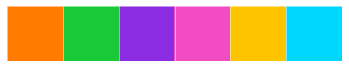

In [21]:
##For sourcedata
palette = sns.color_palette('bright',10) ###########CAUTION: HARD-CODED (max 6 colors)
palette = [color for i,color in enumerate(palette) if not(i in [0,3,5,7])]
sns.palplot(palette)
palette = ['orange','green','purple','pink','yellow','skyblue']
for tmp_sample_prefix in ['mRNA','RPF','QTI']:
    print('-------'+tmp_sample_prefix+'-------')
    tmp_DEG_df_list   = []
    tmp_hpi_list      = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]
    clusterFname=f'timecourse_hostexp/{tmp_sample_prefix}_cluster.tsv'
    ID_cl_df          = pd.read_csv(RESULTDIR %clusterFname, sep = '\t', index_col = 0)
    ID_cl_df['color'] = [palette[i-1] for i in ID_cl_df['cluster']]
    timecourse_df     = pd.read_csv(RESULTDIR %(f'timecourse_hostexp/{tmp_sample_prefix}_timecourse.tsv'), sep = '\t',index_col = 0)
    timecourse_DEG_df = timecourse_df.loc[ID_cl_df.index]
    timecourse_DEG_df['cluster'] = ID_cl_df['color']
    timecourse_DEG_df.to_csv(RESULTDIR %(f'timecourse_hostexp/{tmp_sample_prefix}_timecourse_DEG.tsv'), sep = '\t')
    cluster_mean = timecourse_DEG_df.groupby('cluster').mean()
    cluster_std  = timecourse_DEG_df.groupby('cluster').std()
    display(cluster_mean)
    display(cluster_std)
    #display(cluster_n)
    #cluster_CI95 = cluster_std/np.sqrt(cluster_n)*1.96
    #display(cluster_CI95)

### Fig. 6a-c: Inspection of the genes of interest

In [13]:
def plot_Fig6abc_multipanel(OutFigname=''):
    #Fig.6a: Gordon et al + ACE2, TMPRSS2
    Fig6a_df = pd.DataFrame(columns = ['color','linewidth','print_cutoff','genelist'])
    Fig6a_df.loc['Gordonetal']  = ['#a52a2a', 0.5, 100.0, [i.strip().upper() for i in open(GENELISTDIR %'Gordonetal_interacting_proteins')]]
    Fig6a_df.loc['ACE2+TMPRSS2']= ['blue',    1.0, 0.0,   ['ACE2', 'TMPRSS2']]
    #Fig. 6b: IFN_typeI_III+Blancomelo_IFN1response_DEGs_sig
    Fig6b_df = pd.DataFrame(columns = ['color','linewidth','print_cutoff','genelist'])
    IFN_response_list      = [i.strip().upper() for i in open(GENELISTDIR %'IFN_typeI_III+Blancomelo_IFN1response_DEGs_sig')]
    IFN_list               = [gsym for gsym in IFN_response_list if 'IFN' in gsym]
    others_list            = [gsym for gsym in IFN_response_list if not('IFN' in gsym)]
    Fig6b_df.loc['others'] = ['#a52a2a',    0.5, 100.0, others_list]
    Fig6b_df.loc['IFN']    = ['green',    1.0,   100.0, IFN_list]
    #Fig. 6c: Blancomelo_cytokineDEGs_sig_Fig2+4
    Fig6c_df = pd.DataFrame(columns = ['color','linewidth','print_cutoff','genelist'])
    Fig6c_df.loc['cytokine']  = ['#a52a2a', 0.5, 100.0, [i.strip().upper() for i in open(GENELISTDIR %'Blancomelo_cytokineDEGs_sig_Fig2+4')]]
    
    highlight_gene_info_df_list = [Fig6a_df,Fig6b_df,Fig6c_df]
    tmp_sample_prefix_list = ['mRNA','RPF','QTI']
    
    fig, axes  = plt.subplots(nrows=len(highlight_gene_info_df_list), ncols=len(tmp_sample_prefix_list), 
                              figsize=(3.5*len(tmp_sample_prefix_list), 3*len(highlight_gene_info_df_list)))
    
    for idx_col, tmp_sample_prefix in enumerate(tmp_sample_prefix_list):
        print('------'+tmp_sample_prefix+'------')
        tmp_DEG_df_list   = []
        tmp_hpi_list      = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]
        for hpi in tmp_hpi_list:
            InFname    = f'DEG/{tmp_sample_prefix}_DESeq2_{hpi}.tsv'
            tmp_DEG_df = pd.read_csv(RESULTDIR %(InFname), sep ='\t', header=0, index_col=0)
            tmp_DEG_df_list.append(tmp_DEG_df)
        
        for idx_row, highlight_gene_info_df in enumerate(highlight_gene_info_df_list):
            display(highlight_gene_info_df)
            ax = axes[idx_row,idx_col]
            _             = timecourse_plot(tmp_DEG_df_list,tmp_hpi_list, padj_cut=0.01, log2fc_cut=2, clip = 2.8,
                                        ylim = 5, n_cluster=5, as_average=False, 
                                        load_precalc_clusters=True, clusterFname=f'timecourse_hostexp/{tmp_sample_prefix}_cluster.tsv',
                                        clusters_to_show=[], clusters_priority=[], highlight_gene_info_df = highlight_gene_info_df,
                                        cl_method='ward',cl_metric='euclidean',ax = ax, 
                                        OutFigname='', show_fig=False, verbose=False)
    if OutFigname != '':
        #plt.tight_layout()
        plt.savefig(FIGDIR %OutFigname)
        plt.close()
    else:
        #plt.tight_layout()
        plt.show()
        plt.close()
    return None



In [31]:
##source data for Fig. 6a
Fig6a_df = pd.DataFrame(columns = ['color','linewidth','print_cutoff','genelist'])
Fig6a_df.loc['Gordonetal']  = ['#a52a2a', 0.5, 100.0, [i.strip().upper() for i in open(GENELISTDIR %'Gordonetal_interacting_proteins')]]
Fig6a_df.loc['ACE2+TMPRSS2']= ['blue',    1.0, 0.0,   ['ACE2', 'TMPRSS2']]
#Fig. 6b: Daniloski targets
Fig6b_df = pd.DataFrame(columns = ['color','linewidth','print_cutoff','genelist'])
hostfactors_drugtargets = pd.read_csv(GENELISTDIR %'Daniloski_MOI03_dgidb',sep='\t').iloc[:,0].str.upper().tolist()
hostfactors = pd.read_csv(GENELISTDIR %'Daniloski_MOI03_rank',sep='\t').iloc[:,0].str.upper().tolist()
hostfactors_nontargets  = list(set(hostfactors)-set(hostfactors_drugtargets))
Fig6b_df.loc['Daniloski_hostfactors_nontargets'] = ['#a52a2a', 0.5, 1.5, hostfactors_nontargets]
Fig6b_df.loc['Daniloski_hostfactors_drugtargets']= ['magenta', 1.0, 1.5, hostfactors_drugtargets]

#Fig. 6d: IFN_typeI_III+Blancomelo_IFN1response_DEGs_sig
Fig6d_df = pd.DataFrame(columns = ['color','linewidth','print_cutoff','genelist'])
IFN_response_list      = [i.strip().upper() for i in open(GENELISTDIR %'IFN_typeI_III+Blancomelo_IFN1response_DEGs_sig')]
IFN_list               = [gsym for gsym in IFN_response_list if 'IFN' in gsym]
others_list            = [gsym for gsym in IFN_response_list if not('IFN' in gsym)]
Fig6d_df.loc['others'] = ['#a52a2a',    0.5, 100.0, others_list]
Fig6d_df.loc['IFN']    = ['green',    1.0,   100.0, IFN_list]
#Fig. 6e: Blancomelo_cytokineDEGs_sig_Fig2+4
Fig6e_df = pd.DataFrame(columns = ['color','linewidth','print_cutoff','genelist'])
Fig6e_df.loc['cytokine']  = ['#a52a2a', 0.5, 100.0, [i.strip().upper() for i in open(GENELISTDIR %'Blancomelo_cytokineDEGs_sig_Fig2+4')]]

#Fig. 6i: eIFs related to the start codon recognition fidelity and non-AUC translation
Fig6i_df = pd.DataFrame(columns = ['color','linewidth','print_cutoff','genelist'])

Fig6i_df.loc['nonAUG_enhancers']       = ['red', 0.5, 1.5, ['EIF5B','EIF2A','EIF2D']]
Fig6i_df.loc['nonAUG_enhancers_eIF5']  = ['red', 1.0, 1.5, ['EIF5']] #eIF5 alone for thicker line
Fig6i_df.loc['nonAUG_repressors']      = ['blue', 0.5, 1.5, ['EIF1','EIF1AX','EIF1AY']]

highlight_gene_info_df_list = [Fig6a_df, Fig6b_df, Fig6d_df, Fig6e_df, Fig6i_df]
highlight_gene_name_list    = ['Fig6a', 'Fig6b', 'Fig6d', 'Fig6e', 'Fig6i']
for highlight_gene_name, highlight_gene_info_df in zip(highlight_gene_name_list, highlight_gene_info_df_list):
    ID_subgroup_df = pd.DataFrame(columns=['subgroup'], index = [i for genelist in highlight_gene_info_df['genelist'] for i in genelist ])
    for subgroup, row in highlight_gene_info_df.iterrows():
        ID_subgroup_df.loc[row['genelist']] = subgroup
    #display(ID_subgroup_df)
    for tmp_sample_prefix in ['mRNA','RPF','QTI']:
        print('-------'+tmp_sample_prefix+'-------')
        tmp_DEG_df_list   = []
        tmp_hpi_list      = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]
        clusterFname=f'timecourse_hostexp/{tmp_sample_prefix}_cluster.tsv'
        timecourse_df     = pd.read_csv(RESULTDIR %(f'timecourse_hostexp/{tmp_sample_prefix}_timecourse.tsv'), sep = '\t',index_col = 0)



        timecourse_DEG_df = timecourse_df.loc[ID_subgroup_df.index]
        timecourse_DEG_df['subgroup'] = ID_subgroup_df['subgroup']
        timecourse_DEG_df = timecourse_DEG_df.dropna()
        timecourse_DEG_df.to_csv(RESULTDIR %(f'timecourse_hostexp/{highlight_gene_name}_{tmp_sample_prefix}_timecourse_Fig6genes.tsv'), sep = '\t')
        

-------mRNA-------
-------RPF-------
-------QTI-------
-------mRNA-------
-------RPF-------


/home/sonic/baeklab/Hyeonseong/anaconda3/envs/Doyeon-tf2/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


-------QTI-------
-------mRNA-------
-------RPF-------
-------QTI-------
-------mRNA-------
-------RPF-------
-------QTI-------
-------mRNA-------
-------RPF-------
-------QTI-------


In [14]:
plot_Fig6abc_multipanel(OutFigname='Fig5_timecourse_hostexp/Fig6abc_reported_genes_timecourse.pdf')

------mRNA------


,color,linewidth,print_cutoff,genelist
Gordonetal,#a52a2a,0.5,100.0,"[PCNT, PVR, POLA1, FASTKD5, PRIM2, ITGB1, CNTR..."
ACE2+TMPRSS2,blue,1.0,0.0,"[ACE2, TMPRSS2]"


,color,linewidth,print_cutoff,genelist
others,#a52a2a,0.5,100.0,"[MX1, XAF1, OAS1, IFITM1, OAS3, IRF9, OAS2, IR..."
IFN,green,1.0,100.0,"[IFNA1, IFNA2, IFNA4, IFNA5, IFNA6, IFNA7, IFN..."


,color,linewidth,print_cutoff,genelist
cytokine,#a52a2a,0.5,100.0,"[CCL2, CCL20, CCL8, CSF2, CSF3, CXCL1, CXCL14,..."


------RPF------


,color,linewidth,print_cutoff,genelist
Gordonetal,#a52a2a,0.5,100.0,"[PCNT, PVR, POLA1, FASTKD5, PRIM2, ITGB1, CNTR..."
ACE2+TMPRSS2,blue,1.0,0.0,"[ACE2, TMPRSS2]"


,color,linewidth,print_cutoff,genelist
others,#a52a2a,0.5,100.0,"[MX1, XAF1, OAS1, IFITM1, OAS3, IRF9, OAS2, IR..."
IFN,green,1.0,100.0,"[IFNA1, IFNA2, IFNA4, IFNA5, IFNA6, IFNA7, IFN..."


,color,linewidth,print_cutoff,genelist
cytokine,#a52a2a,0.5,100.0,"[CCL2, CCL20, CCL8, CSF2, CSF3, CXCL1, CXCL14,..."


------QTI------


,color,linewidth,print_cutoff,genelist
Gordonetal,#a52a2a,0.5,100.0,"[PCNT, PVR, POLA1, FASTKD5, PRIM2, ITGB1, CNTR..."
ACE2+TMPRSS2,blue,1.0,0.0,"[ACE2, TMPRSS2]"


,color,linewidth,print_cutoff,genelist
others,#a52a2a,0.5,100.0,"[MX1, XAF1, OAS1, IFITM1, OAS3, IRF9, OAS2, IR..."
IFN,green,1.0,100.0,"[IFNA1, IFNA2, IFNA4, IFNA5, IFNA6, IFNA7, IFN..."


,color,linewidth,print_cutoff,genelist
cytokine,#a52a2a,0.5,100.0,"[CCL2, CCL20, CCL8, CSF2, CSF3, CXCL1, CXCL14,..."


### Fig. R: Inspection of the genes of pathophysiological relevance

In [15]:
def plot_FigR_pathophysio_multipanel(OutFigname=''):
    #Fig.Rx: Daniloski et al. MOI0.3,CRISPR log2fc>1 host factors (drugtargets: subgroup)
    FigRx_df = pd.DataFrame(columns = ['color','linewidth','print_cutoff','genelist'])
    hostfactors_drugtargets = pd.read_csv(GENELISTDIR %'Daniloski_MOI03_dgidb',sep='\t').iloc[:,0].str.upper().tolist()
    hostfactors = pd.read_csv(GENELISTDIR %'Daniloski_MOI03_rank',sep='\t').iloc[:,0].str.upper().tolist()
    hostfactors_nontargets  = list(set(hostfactors)-set(hostfactors_drugtargets))
    FigRx_df.loc['Daniloski_hostfactors_nontargets'] = ['#a52a2a', 0.5, 1.5, hostfactors_nontargets]
    FigRx_df.loc['Daniloski_hostfactors_drugtargets']= ['magenta', 1.0, 1.5, hostfactors_drugtargets]
    
    #Fig.Ry: eIFs related to the start codon recognition fidelity and non-AUC translation
    FigRy_df = pd.DataFrame(columns = ['color','linewidth','print_cutoff','genelist'])
    
    FigRy_df.loc['nonAUG_enhancers']       = ['red', 0.5, 1.5, ['EIF5B','EIF2A','EIF2D']]
    FigRy_df.loc['nonAUG_enhancers_eIF5']  = ['red', 1.0, 1.5, ['EIF5']] #eIF5 alone for thicker line
    FigRy_df.loc['nonAUG_repressors']      = ['blue', 0.5, 1.5, ['EIF1','EIF1AX','EIF1AY']]
    
    highlight_gene_info_df_list = [FigRx_df,FigRy_df]
    tmp_sample_prefix_list = ['mRNA','RPF','QTI']
    
    fig, axes  = plt.subplots(nrows=len(highlight_gene_info_df_list), ncols=len(tmp_sample_prefix_list), 
                              figsize=(3.5*len(tmp_sample_prefix_list), 3*len(highlight_gene_info_df_list)))
    
    for idx_col, tmp_sample_prefix in enumerate(tmp_sample_prefix_list):
        print('------'+tmp_sample_prefix+'------')
        tmp_DEG_df_list   = []
        tmp_hpi_list      = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]
        for hpi in tmp_hpi_list:
            InFname    = f'DEG/{tmp_sample_prefix}_DESeq2_{hpi}.tsv'
            tmp_DEG_df = pd.read_csv(RESULTDIR %(InFname), sep ='\t', header=0, index_col=0)
            tmp_DEG_df_list.append(tmp_DEG_df)
        
        for idx_row, highlight_gene_info_df in enumerate(highlight_gene_info_df_list):
            if idx_row == 0:
                ylim = (-5,2.5)
            else:
                ylim = 2.5
            display(highlight_gene_info_df)
            ax = axes[idx_row,idx_col]
            _             = timecourse_plot(tmp_DEG_df_list,tmp_hpi_list, padj_cut=0.01, log2fc_cut=2, clip = 2.8,
                                        ylim = ylim, n_cluster=5, as_average=False, 
                                        load_precalc_clusters=True, clusterFname=f'timecourse_hostexp/{tmp_sample_prefix}_cluster.tsv',
                                        clusters_to_show=[], clusters_priority=[], highlight_gene_info_df = highlight_gene_info_df,
                                        cl_method='ward',cl_metric='euclidean',ax = ax, 
                                        OutFigname='', show_fig=False, verbose=False)
    if OutFigname != '':
        #plt.tight_layout()
        plt.savefig(FIGDIR %OutFigname)
        plt.close()
    else:
        #plt.tight_layout()
        plt.show()
        plt.close()
    return None


In [16]:
plot_FigR_pathophysio_multipanel(OutFigname='Fig5_timecourse_hostexp/FigR_pathophysiology_timecourse.pdf')

------mRNA------


,color,linewidth,print_cutoff,genelist
Daniloski_hostfactors_nontargets,#a52a2a,0.5,1.5,"[GNGT1, ATP6V1G1, SPEN, KIAA1033, UVRAG, PGBD4..."
Daniloski_hostfactors_drugtargets,magenta,1.0,1.5,"[VPS35, ACE2, ATP6V1C1, ATP6V1B2, CTSL, HDAC9,..."


,color,linewidth,print_cutoff,genelist
nonAUG_enhancers,red,0.5,1.5,"[EIF5B, EIF2A, EIF2D]"
nonAUG_enhancers_eIF5,red,1.0,1.5,[EIF5]
nonAUG_repressors,blue,0.5,1.5,"[EIF1, EIF1AX, EIF1AY]"


------RPF------


,color,linewidth,print_cutoff,genelist
Daniloski_hostfactors_nontargets,#a52a2a,0.5,1.5,"[GNGT1, ATP6V1G1, SPEN, KIAA1033, UVRAG, PGBD4..."
Daniloski_hostfactors_drugtargets,magenta,1.0,1.5,"[VPS35, ACE2, ATP6V1C1, ATP6V1B2, CTSL, HDAC9,..."


,color,linewidth,print_cutoff,genelist
nonAUG_enhancers,red,0.5,1.5,"[EIF5B, EIF2A, EIF2D]"
nonAUG_enhancers_eIF5,red,1.0,1.5,[EIF5]
nonAUG_repressors,blue,0.5,1.5,"[EIF1, EIF1AX, EIF1AY]"


------QTI------


,color,linewidth,print_cutoff,genelist
Daniloski_hostfactors_nontargets,#a52a2a,0.5,1.5,"[GNGT1, ATP6V1G1, SPEN, KIAA1033, UVRAG, PGBD4..."
Daniloski_hostfactors_drugtargets,magenta,1.0,1.5,"[VPS35, ACE2, ATP6V1C1, ATP6V1B2, CTSL, HDAC9,..."


,color,linewidth,print_cutoff,genelist
nonAUG_enhancers,red,0.5,1.5,"[EIF5B, EIF2A, EIF2D]"
nonAUG_enhancers_eIF5,red,1.0,1.5,[EIF5]
nonAUG_repressors,blue,0.5,1.5,"[EIF1, EIF1AX, EIF1AY]"


### Fig.R: correlation b/w max(|log2fc|) ~ Daniloski et al. physiological impact

In [32]:
def calc_plot_assoc_lfc_physioimpact(sample_prefix='RPF', OutFigname=''):
    tmp_DEG_df_list   = []
    tmp_hpi_list      = ['%dh' %i for i in [0,1,2,4,12,16,24,36]]
    for hpi in tmp_hpi_list:
        InFname    = f'DEG/{sample_prefix}_DESeq2_{hpi}.tsv'
        tmp_DEG_df = pd.read_csv(RESULTDIR %(InFname), sep ='\t', header=0, index_col=0)
        tmp_DEG_df_list.append(tmp_DEG_df)
        
    
    hostfactors_df = pd.read_csv(GENELISTDIR %'Daniloski_MOI03_rank',sep='\t')
    hostfactors_df['gsym'] = hostfactors_df['gsym'].str.upper()
    hostfactors    = hostfactors_df['gsym']
    hostfactors_df = hostfactors_df.set_index('gsym')
    
    hostfactors_drugtargets = pd.read_csv(GENELISTDIR %'Daniloski_MOI03_dgidb',sep='\t').iloc[:,0].str.upper().tolist()
    
    timecourse_df = pd.read_csv(RESULTDIR %(f'timecourse_hostexp/{sample_prefix}_timecourse.tsv'), 
                                sep = '\t', index_col = 0)
    timecourse_df = timecourse_df.loc[hostfactors]
    timecourse_df['max'] = timecourse_df.abs().max(axis=1)
    timecourse_df['rank']= hostfactors_df['rank']
    timecourse_df['lfc'] = hostfactors_df['lfc']
    timecourse_df = timecourse_df.dropna(how='any')
    colors = ['magenta' if i in hostfactors_drugtargets else '#a52a2a' for i in timecourse_df.index]
    print('vs. maxabs',stats.spearmanr(timecourse_df['lfc'],timecourse_df['max']))
    print('vs. 36h',   stats.spearmanr(timecourse_df['lfc'],timecourse_df['36h']))
    print('vs. max',   stats.spearmanr(timecourse_df['lfc'],timecourse_df[tmp_hpi_list].max(axis=1)))
    print('vs. min',   stats.spearmanr(timecourse_df['lfc'],timecourse_df[tmp_hpi_list].min(axis=1)))
    
    xvar = 'max'
    yvar = 'rank'
    fig  = plt.figure(figsize=(3.5,3.5))
    display(timecourse_df.sort_values(xvar,ascending=False).head(5))
    plt.scatter(timecourse_df[xvar],timecourse_df[yvar], c = colors)
    plt.ylabel('CRISPR screening rank')
    plt.xlabel('max(|log2fc|)')
    plt.ylim(bottom=0)
    timecourse_df[[xvar,yvar]].to_csv(RESULTDIR %(f'timecourse_hostexp/Fig6i_correlation.tsv'), 
                                      sep = '\t')
    z = np.polyfit( timecourse_df[xvar], timecourse_df[yvar],1)
    p = np.poly1d(z)
    plt.plot(timecourse_df[xvar].sort_values(),p(timecourse_df[xvar].sort_values()),"k--")
    sprho, spp = stats.spearmanr(timecourse_df[xvar],timecourse_df[yvar])
    plt.text(timecourse_df[xvar].max()/2,timecourse_df[yvar].max()/1.1,f'Spearman rho={sprho:.03f}\nP={spp:.02e}')
    
    plt.tight_layout()
    if OutFigname != '':
        plt.savefig(FIGDIR %OutFigname)
    else:
        plt.show()
    plt.close()
    
    return None

calc_plot_assoc_lfc_physioimpact(sample_prefix = 'RPF', OutFigname='Fig5_timecourse_hostexp/FigR_phyiological_assoc.pdf')

vs. maxabs SpearmanrResult(correlation=0.387003406631181, pvalue=0.0007844012325431527)
vs. 36h SpearmanrResult(correlation=-0.16277839064274974, pvalue=0.17188299305160892)
vs. max SpearmanrResult(correlation=0.04946490811923513, pvalue=0.679877249165559)
vs. min SpearmanrResult(correlation=-0.2555169426117058, pvalue=0.030289291368957135)


/home/sonic/baeklab/Hyeonseong/anaconda3/envs/Doyeon-tf2/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


,0h,1h,2h,4h,12h,16h,24h,36h,max,rank,lfc
id,,,,,,,,,,,
ACE2,-6.607765e-06,-0.000702,-0.055994,-0.319392,-2.566465,-3.545599,-3.782672,-4.101040,4.101040,12,1.6266
ATP6AP2,-8.086250e-06,0.001427,0.116543,0.130180,-1.579491,-2.076438,-2.049512,-1.855499,2.076438,5,2.0384
SRSF1,1.806937e-06,0.004399,0.659602,1.374653,1.379408,1.851016,1.163534,0.166559,1.851016,30,1.2700
COMMD4,-9.434869e-07,-0.000646,-0.057539,-0.217448,-1.021387,-0.324847,-0.372262,-1.518002,1.518002,38,1.1835
ATP6V1G1,-2.726768e-06,-0.000727,0.044275,0.437669,1.441861,1.310660,1.383131,1.245990,1.441861,15,1.5741
